In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import json

# Local Weather Forcast

### Get your computer's GPS location.
Call API with your IP address

Clean & store the returned GPS coordinates & location's name

In [2]:
## set up environment
import requests
import json


## get location JSON from an API using your computer's IP address
responseLocation = requests.get("http://ip-api.com/json/")
locationJSON = json.loads(responseLocation.text)

# select just the needed info from API
country = str(locationJSON['country'])
countryCode = str(locationJSON['countryCode'])
region = str(locationJSON['region'])
regionName = str(locationJSON['regionName'])
city = str(locationJSON['city'])
longitude = str(locationJSON['lon'])
latitude = str(locationJSON['lat'])

## for trouble shooting
# print(locationJSON)
# print([city, region, country, longitude, latitude])

## Alternat locations for trouble shooting
# city =  'San Francisco'
# regionName = 'California'
# longitude = '-122.463'
# latitude = '37.7648'

# city = 'New York City'
# regionName = 'New York'
# longitude = '-73.9808'
# latitude = '40.648'

### Get your location as measured by the US National Weather Service
Call API with your GPS cordinates 

Receive your location's grid location

In [3]:
## Set up environment
import requests
import json
import pandas as pd

## Get your location in the units that the US National Weather Service uses using GPS cordinates from the prevouse API call.
baseURL = "https://api.weather.gov/"
responseGetGrid = requests.get(baseURL + 'points/' + latitude + ',' + longitude)
data = responseGetGrid.text
parse_json = json.loads(data)

## Record your location as measured by the US National Weather Service.
## This is for the next API call for data from the US National Weather Service. 
gridId = str(parse_json['properties']['gridId'])
gridX = str(parse_json['properties']['gridX'])
gridY = str(parse_json['properties']['gridY'])

## grid explination...
    ## The National weather service divides the US into different regions each with a gridId.
    ## Each gridId is subdivided into different polygon shaped areas.
    ## Each of these areas are named by their gridX & gridY.
    ## Each area has 1 set of weather data that will be retreived in the next step.

### Get your local weather data
Call API with your grid location

Clean, transform to imperial units, & organize data

Fill gaps in data set acording to API's documentation

In [4]:


## Call API with your grid location
responseGetWeather = json.loads(requests.get(baseURL + 'gridpoints/' + gridId + '/' + gridX + ',' + gridY).text)

## Make list of all the measurments to keep from API's JSON
measurments = pd.DataFrame(responseGetWeather['properties']).columns[[(range(9,66))]]

## Make new dataFrame to collect data
bigDF=pd.DataFrame({'dateTime':[]})

## Merge data from each of the listed measurments into the new dataFrame
for i in measurments:
    ## This gets rid of measurements that do not have units ('uom' stands for Unit Of Measure)
    if 'uom' in responseGetWeather['properties'][i]:
        ## pull each data set into temporary dataFrame
        loopDF = pd.DataFrame(responseGetWeather['properties'][i]['values'])
        ## clean data (remove trailing 'validTime' info that is not dateTime data, Change data type to datetime, make new column, & put info into that new column)
        loopDF['dateTime']=pd.to_datetime(loopDF.validTime.str.slice(0,19))
        ## drop original 'validTime'
        loopDF.drop(columns='validTime',inplace=True)
        ## get unitOfMeasure for i
        unitOfMeasure = responseGetWeather['properties'][i]['uom']
        ## make temporary variable where name of measurment + unit are concatenated
        ## the unit of measurment is cleaned up with the substring. 
        measureWithUnit=(i+"_"+(unitOfMeasure[8:]))

        ## find the metric units
        ## if metric add column to dataFrame with new imperial name and converted values
        if (unitOfMeasure[8:]) == 'degC':
            loopDF[(i+'_degF')] = loopDF.value.mul(1.8).add(32)
        elif (unitOfMeasure[8:]) == 'km_h-1':
            loopDF[(i+'_MPH')] = loopDF.value.div(1.609344)
        elif (unitOfMeasure[8:]) == 'm':
            loopDF[(i+'_ft')] = loopDF.value.mul(3.28)
        elif (unitOfMeasure[8:]) == 'mm':
            loopDF[(i+'_in')] = loopDF.value.div(25.4)
        else:
            lunch='good'

        ## change genaric column label to be the measue name with units (i.e. temperature_degF)
        loopDF.rename(columns={'value':measureWithUnit},inplace=True)
        ## merge new loopDF into the bigDF with both metric & imperial units columns
        bigDF=pd.merge(bigDF,loopDF, how='outer',on='dateTime')
    else:
        # end if loop to exclude values without units since they lack a uniform JSON structrue & the data is not needed for this project
        dinner='good'

bigDF['time'] = bigDF.dateTime
## set dateTime as index
bigDF.set_index('dateTime',inplace=True)
## sort index to ascending
## this must be done before the fill NA or the wrong numbers will get filling into the wrong data gaps
bigDF.sort_index(ascending=True,inplace=True)
## fill gaps in the dataFrame with forward fill method. 
## The forwar fill method was chosen based on the API's documentation. When a value is identical to the previouse value it is dropped to save server time.
## Bug started on 2022DEC01 because the minTemp provided goes out to 9 days causing all other values to ffill to 9 days.
bigDF.fillna(method='ffill',inplace=True)



## for troubleshooting
# bigDF.plot()
# bigDF.head()
# print(baseURL + 'gridpoints/' + gridId + '/' + gridX + ',' + gridY)

/home/master/.local/lib/python3.8/site-packages/pandas/core/indexes/base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


## 7-Day Weather Report with Pandas

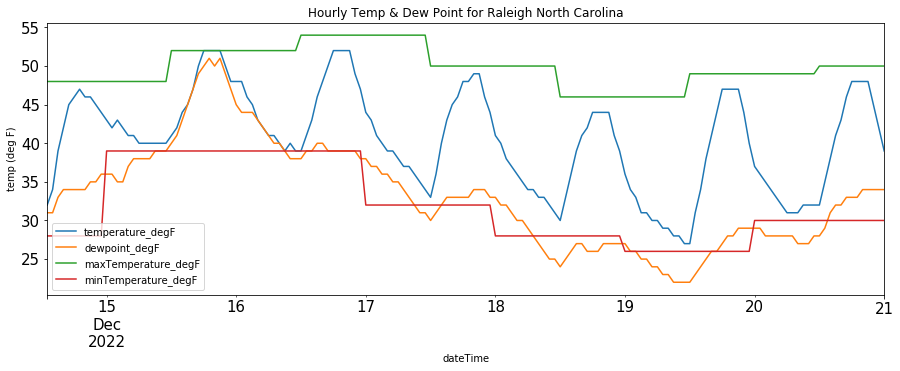

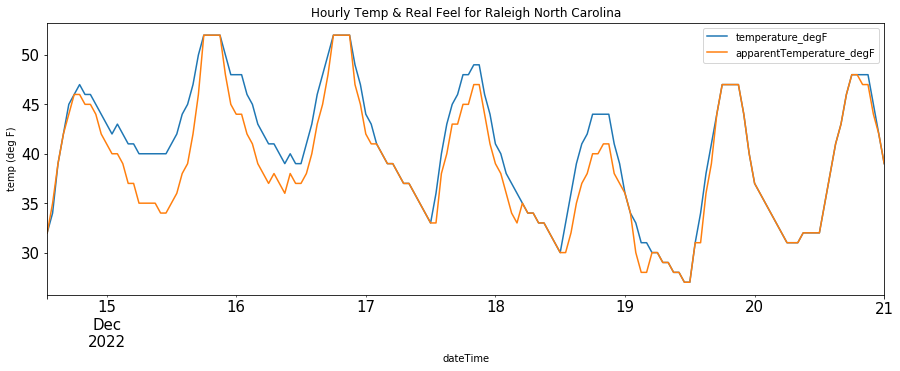

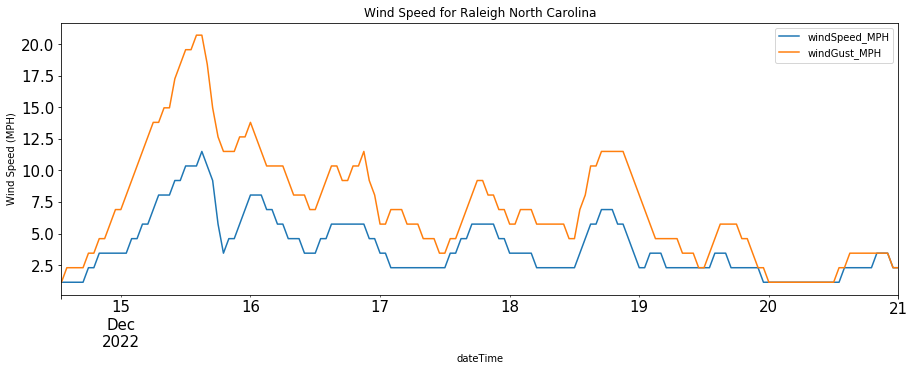

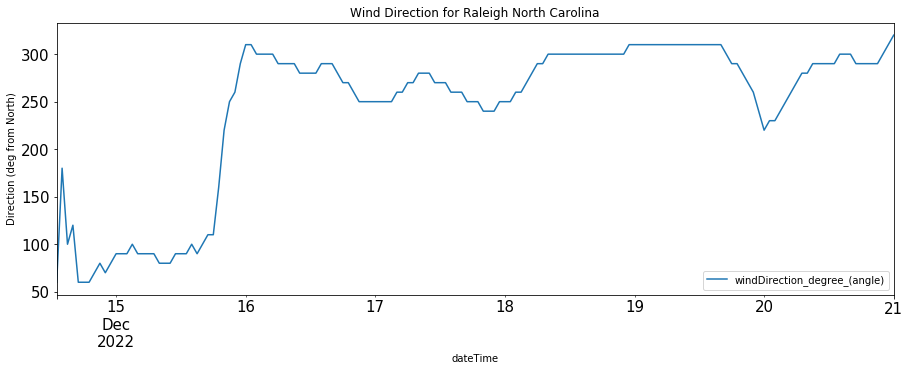

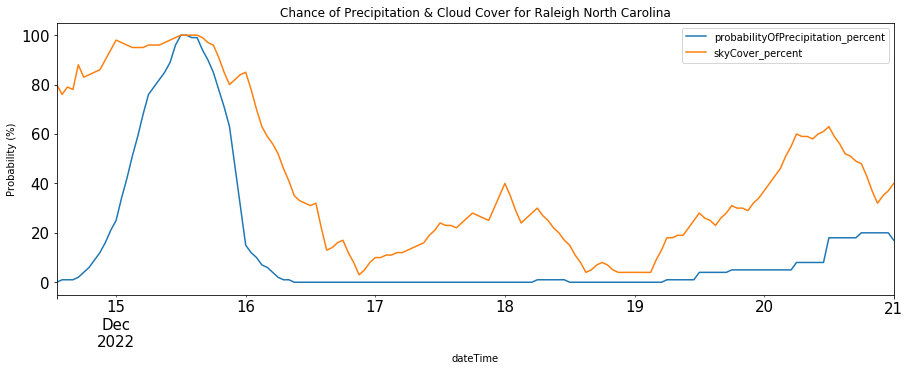

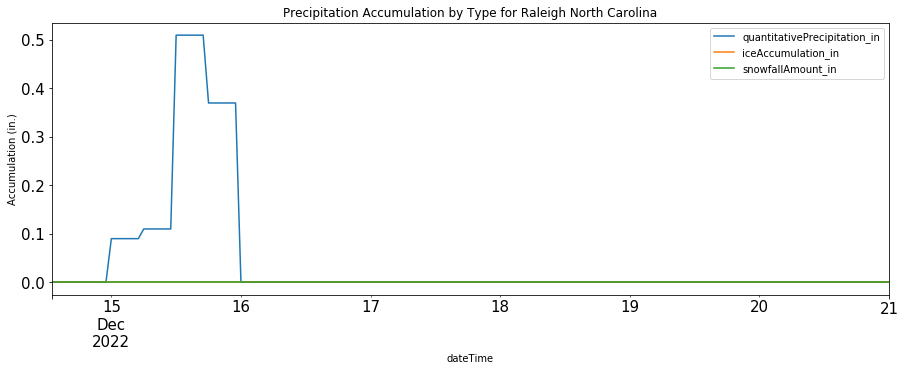

In [5]:
## 6 Weather Plots (7-day)

plotTempF_DF = bigDF.iloc[:,[1,3,5,7]]
plotTempF_DF.plot(
    figsize=(15,5),
    title=('Hourly Temp & Dew Point for ' + city +' '+ regionName),
    ylabel='temp (deg F)',
    fontsize=15,
    mark_right=True)

plotApparentTempF_DF = bigDF.iloc[:,[1,10]]
plotApparentTempF_DF.plot(
    figsize=(15,5),
    title=('Hourly Temp & Real Feel for ' + city +' '+ regionName),
    ylabel='temp (deg F)',
    fontsize=15,
    mark_right=True)


plotWind_DF = bigDF.iloc[:,[18,20]]
plotWind_DF.plot(
    figsize=(15,5),
    title=('Wind Speed for ' + city +' '+ regionName),
    ylabel='Wind Speed (MPH)',
    fontsize=15,
    mark_right=True)

plotWindDirection_DF = bigDF.iloc[:,[16]]
plotWindDirection_DF.plot(
    figsize=(15,5),
    title=('Wind Direction for ' + city +' '+ regionName),
    ylabel='Direction (deg from North)',
    fontsize=15,
    mark_right=True)

plotRainCloudsDF =bigDF.iloc[:,[21,15]]
plotRainCloudsDF.plot(
    figsize=(15,5),
    title=('Chance of Precipitation & Cloud Cover for ' + city +' '+ regionName),
    ylabel='Probability (%)',
    fontsize=15,
    mark_right=True)

plotAmountPrecipitaion_DF = bigDF.iloc[:,[23,25,27]]
plotAmountPrecipitaion_DF.plot(
    figsize=(15,5),
    title=('Precipitation Accumulation by Type for ' + city +' '+ regionName),
    ylabel='Accumulation (in.)',
    fontsize=15,
    mark_right=True)

## Today's Weather Report

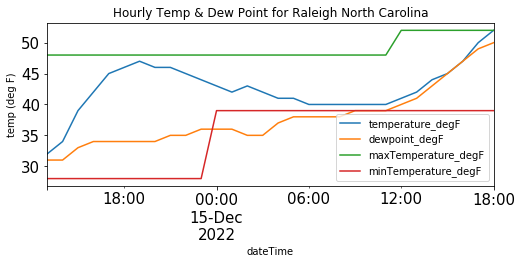

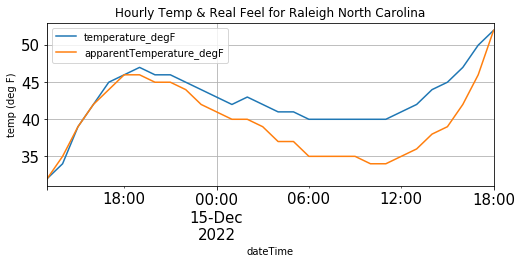

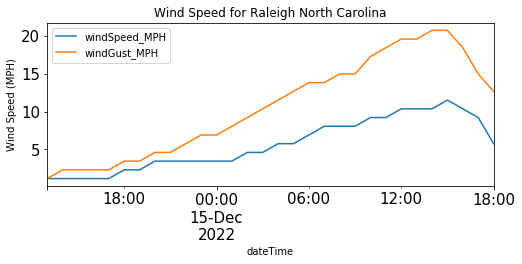

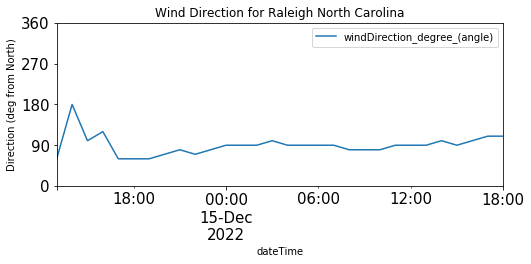

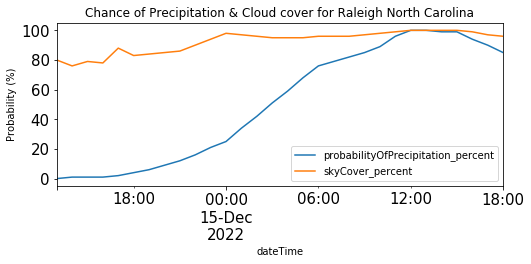

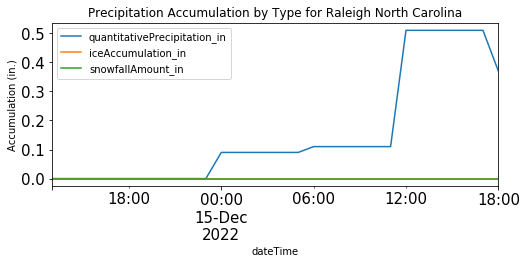

In [6]:
## 6 Weather Plots (30 hour)

duration = 30
size = (8,3)

plotTempF_DF = bigDF.iloc[:,[1,3,5,7]]
plotTempF_DF.head(duration).plot(
    figsize= size,
    title=('Hourly Temp & Dew Point for ' + city +' '+ regionName),
    ylabel='temp (deg F)',
    fontsize=15,
    mark_right=True)

plotApparentTempF_DF = bigDF.iloc[:,[1,10]]
plotApparentTempF_DF.head(duration).plot(
    figsize= size,
    title=('Hourly Temp & Real Feel for ' + city +' '+ regionName),
    ylabel='temp (deg F)',
    fontsize=15,
    mark_right=True,
    grid=True)

plotWind_DF = bigDF.iloc[:,[18,20]]
plotWind_DF.head(duration).plot(
    figsize= size,
    title=('Wind Speed for ' + city +' '+ regionName),
    ylabel='Wind Speed (MPH)',
    fontsize=15,
    mark_right=True)

plotWindDirection_DF = bigDF.iloc[:,[16]]
plotWindDirection_DF.head(duration).plot(
    figsize= size,
    title=('Wind Direction for ' + city +' '+ regionName),
    ylabel='Direction (deg from North)',
    fontsize=15,
    mark_right=True,
    ylim=(0,360),
    yticks=(0,90,180,270,360))

plotRainCloudsDF =bigDF.iloc[:,[21,15]]
plotRainCloudsDF.head(duration).plot(
    figsize= size,
    title=('Chance of Precipitation & Cloud cover for ' + city +' '+ regionName),
    ylabel='Probability (%)',
    fontsize=15,
    mark_right=True)

plotAmountPrecipitaion_DF = bigDF.iloc[:,[23,25,27]]
plotAmountPrecipitaion_DF.head(duration).plot(
    figsize= size,
    title=('Precipitation Accumulation by Type for ' + city +' '+ regionName),
    ylabel='Accumulation (in.)',
    fontsize=15,
    mark_right=True)

## Make new dataFrames with min/max temperatures & sunrise/set times

These will be used for an upcoming plot

### Get Sun rise & Sun set times

Call API using GPS cordinates to get sun rise & sun set times

Clean, transform, & organize data into dataFrame

In [7]:
## 7 day lists Generated with Sunrise time & sunset time list

## Set up environment
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from datetime import date


## make empty lists to recive sunRise & sunSet times
sunRiseList = []
sunSetList = []

## Make API call 7 times
sunRiseBaseURL = 'https://api.sunrisesunset.io/'

for i in list(range(0,7)):
    ## testDate is today, but then each itteration of the loop is the next day for a total of 7 days
    testDate = datetime.now() + timedelta(days=i)
    ## testDate is full dateTime down to the milliseconde. The substring truncates this to just the date & calls the API
    responseSunRise = requests.get(sunRiseBaseURL + 'json?lat=' + latitude + '&lng=' + longitude + '&date=' + ((str(testDate))[:10]))
    sunText = json.loads(responseSunRise.text)
    ## collect just the sunrise & sunset times & concatinate with the date to look like dateTime
    sunRiseList.append((str(testDate))[:10] + " " + (sunText['results']['sunrise']))
    sunSetList.append((str(testDate))[:10] + " " + (sunText['results']['sunset']))


## for trouble shooting
# print(sunRiseList)
# print(sunSetList)
# print(testDate)
# print(sunRiseBaseURL + 'json?lat=' + latitude + '&lng=' + longitude + '&date=' + ((str(testDate))[:10]))

In [8]:
## Make DF with sunRise dateTime & date
sunRiseDF = pd.DataFrame({'sunRise':sunRiseList})
## Add column with just date sliced out of the sunRise data
sunRiseDF['date'] = sunRiseDF.sunRise.str.slice(0,10)

## repeat for sunSet
sunSetDF = pd.DataFrame({'sunSet':sunSetList})
sunSetDF['date'] = sunSetDF.sunSet.str.slice(0,10)


## for trouble shooting
# print(sunRiseDF)
# print(sunSetDF)

### Make new dataFrames for daily min/max Temperature
All of the data in the bigDF is hourly but only daily is needed for this use.

I don't want to add these sun data to the bigDF because it will creat holes in that dataFrams beacuse these sun data have resolution to the second not the hour. 

Also, this might mess with the forward fill of missing data values (but shouldn't unless the order the code is ran in is non-sequential).

In [9]:
## make empty lists to recive temp data at a rate of 1 data point per day
minTempList = []
minTempValidTime = []
maxTempList = []
maxTempValidTime = []

## loop over 7 days of data
for i in list(range(0,7)):
    ## gather temp data from the API's JSON file, then append it to the new list
    minTempList.append(((responseGetWeather['properties']['minTemperature']['values'][i]['value'])))
    ## gather date for each value from previouse line
    minTempValidTime.append(((responseGetWeather['properties']['minTemperature']['values'][i]['validTime'])))
    ## repeate for maxTemp
    maxTempList.append(((responseGetWeather['properties']['maxTemperature']['values'][i]['value'])))
    maxTempValidTime.append(((responseGetWeather['properties']['maxTemperature']['values'][i]['validTime'])))

## put minTemp data into dataFrame
minTempDF = pd.DataFrame(
    {'minTemp':minTempList, 
    'dATE':minTempValidTime,})
## slice out just the date from the API's ValidTime
minTempDF['date'] = minTempDF.dATE.str.slice(0,10)
## drop the API's ValidTime
minTempDF.drop(columns=['dATE'], inplace=True)
## convert degC to degF
minTempDF.minTemp = minTempDF.minTemp.mul(1.8).add(32)

## Repeat for maxTemp
maxTempDF = pd.DataFrame(
    {'maxTemp':maxTempList,
    'dATE':maxTempValidTime})
maxTempDF['date'] = maxTempDF.dATE.str.slice(0,10)
maxTempDF.drop(columns=['dATE'], inplace=True)
maxTempDF.maxTemp = maxTempDF.maxTemp.mul(1.8).add(32)


## for trouble shooting
# print(minTempDF.head(10))
# print(maxTempDF.head(10))

### Make new dataFrame with merged sun & min/maxTemp data

Merging baised on date is important.

The sunTime API will give sunRise and sunSet for everyday.

The weather API will stop giving the minTemp for today in the afternoon.

This causes a miss alignment of the two data sets if they are not merged carefully

In [10]:
# Merge sun and min/max Temp into 1 new dataFrame called sunTempDF
sunTempDF = pd.merge(sunRiseDF, minTempDF, how='outer', on='date')
sunTempDF = pd.merge(sunTempDF, sunSetDF, how='outer', on='date')
sunTempDF = pd.merge(sunTempDF, maxTempDF, how='outer', on='date')
sunTempDF.sort_values('date', ascending=True, inplace=True)
sunTempDF.reset_index(inplace= True)
sunTempDF.drop(columns='index', inplace= True)

# change data type to datetime from object
for i in ['sunRise', 'date', 'sunSet']:
    sunTempDF[i] = pd.to_datetime(sunTempDF[i])

## for trouble shooting
# sunTempDF.info()
# sunTempDF.info()
# sunTempDF

## Us matplotlib.pyplot to Plot hourly temp with scatter point for sunRise/minTemp and sunSet/maxTemp

Temp with (sunrise,minTemp) & (sunset,maxTemp) data points

This is a bit unintuative but it is nice to show how sunrise/set are coralated with when to rate temperature change is positive & negative.

Also, it is a way to show combinding two different data sets from two different APIs in one graph with two different dataFrames and two different plot types.

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


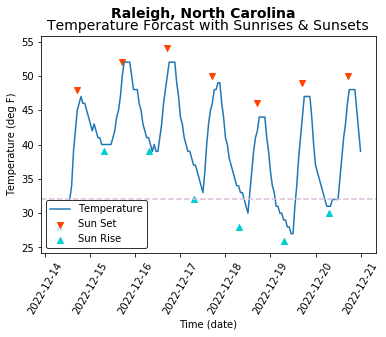

In [11]:
## make plots with matplotlib.pyplot since the sunTimes are too complex to easily do with pandas plot
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.axes

# ax = plt.subplots()
fig = plt.figure()
# ax.plot(bigDF.time, bigDF.temperature_degF)#.set_ylabel('y_label')
plt.plot(bigDF.time, bigDF.temperature_degF, label= 'Temperature')#.set_ylabel('y_label')
plt.scatter(sunTempDF.sunSet, sunTempDF.maxTemp, c= 'orangered', marker='v',label='Sun Set')
plt.scatter(sunTempDF.sunRise, sunTempDF.minTemp, c= 'darkturquoise', marker= '^',label='Sun Rise')
plt.ylabel('Temperature (deg F)')
plt.xlabel('Time (date)')
plt.xticks(rotation=60)
plt.axhline(y=32, linestyle= '--', c= 'thistle')#, label= 'Freezing')
# plt.legend(['First line','Second scatter', 'First scatter'], fancybox=True)
plt.legend(loc= 'best',frameon= True, fancybox= True,
    facecolor= 'w',
    edgecolor= 'black')#'lower center')
# plt.plot_date(xdate= True)
# plt.axis('tight')
fig.suptitle(city +', '+ regionName, fontsize=14, fontweight='bold')
plt.title('Temperature Forcast with Sunrises & Sunsets', fontsize=14, fontweight='normal')

plt.show()

## TO DO
# add logic that freezing line will only show if min in <40F


# Exploritory Analysis
Look for data with corralation.

In [15]:
from pandas.plotting import scatter_matrix

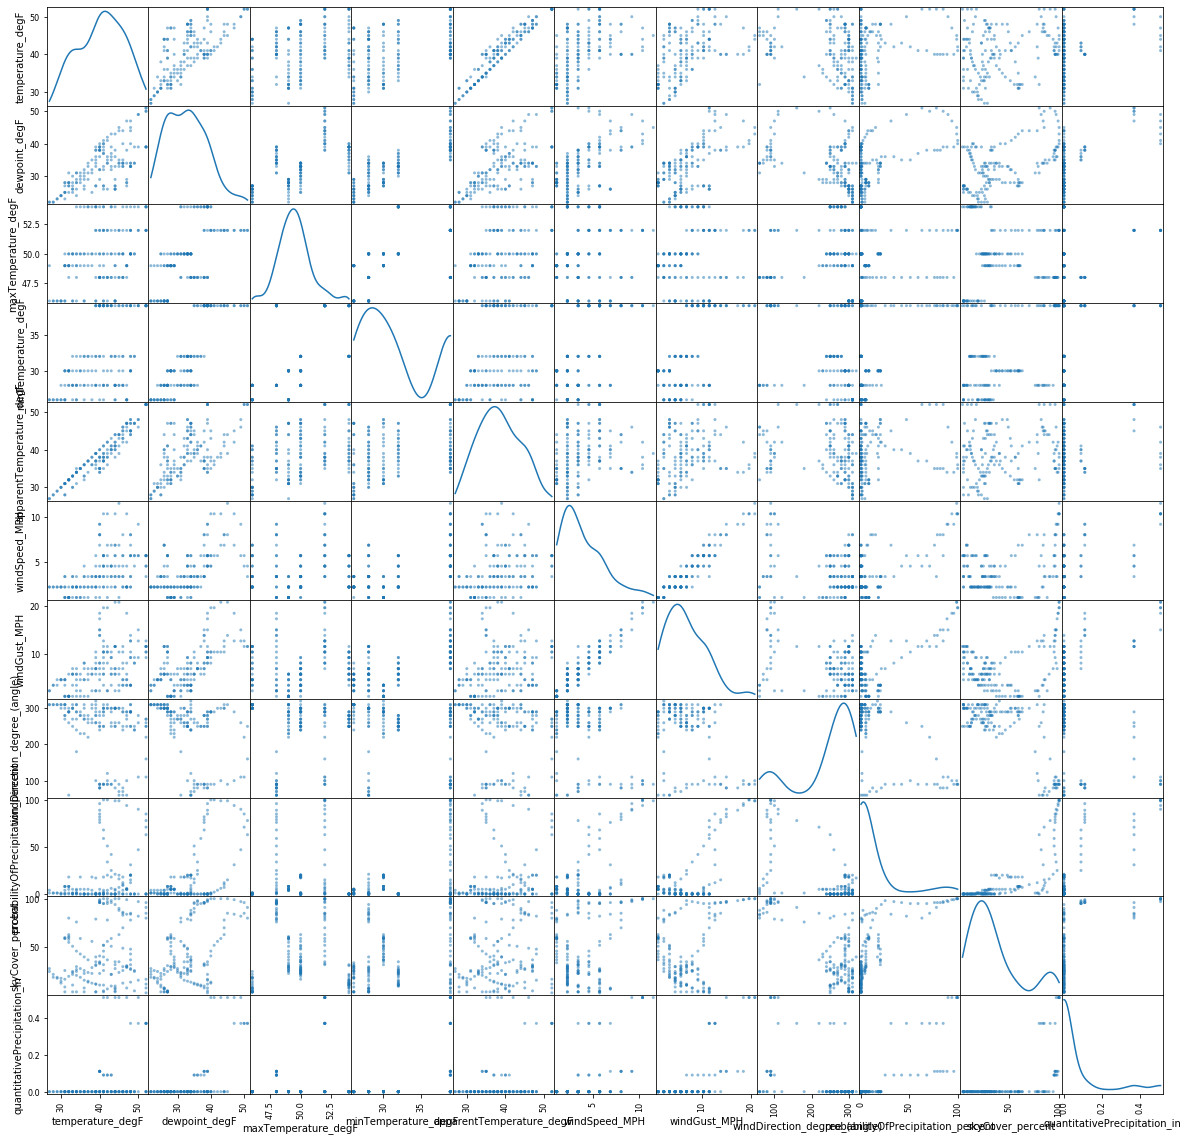

In [16]:
## Looking for Relationships
scatter_matrix(bigDF.iloc[:,[1,3,5,7,10,18,20,16,21,15,23]], figsize=(20,20), diagonal='kde'); 

### Which comparisons have a interesting patern?
Temp & dewpoint & aparent temp (weaker) maxTemp & minTemp

windGust & windSpeed (weaker) skyCover

skyCoverage & probability of precipitaion & quantitativePrecipitaion
 
QuantitativePrecipitation has a relationship with several other measurments. However, This looks like a false positive error caused by there being so few data point that are not 0.000 (as shown in the histogram bottom left cell). So, any time this value is >0.000 the other measurments at that time stand out. More data should be collected if these potential relationships have value.

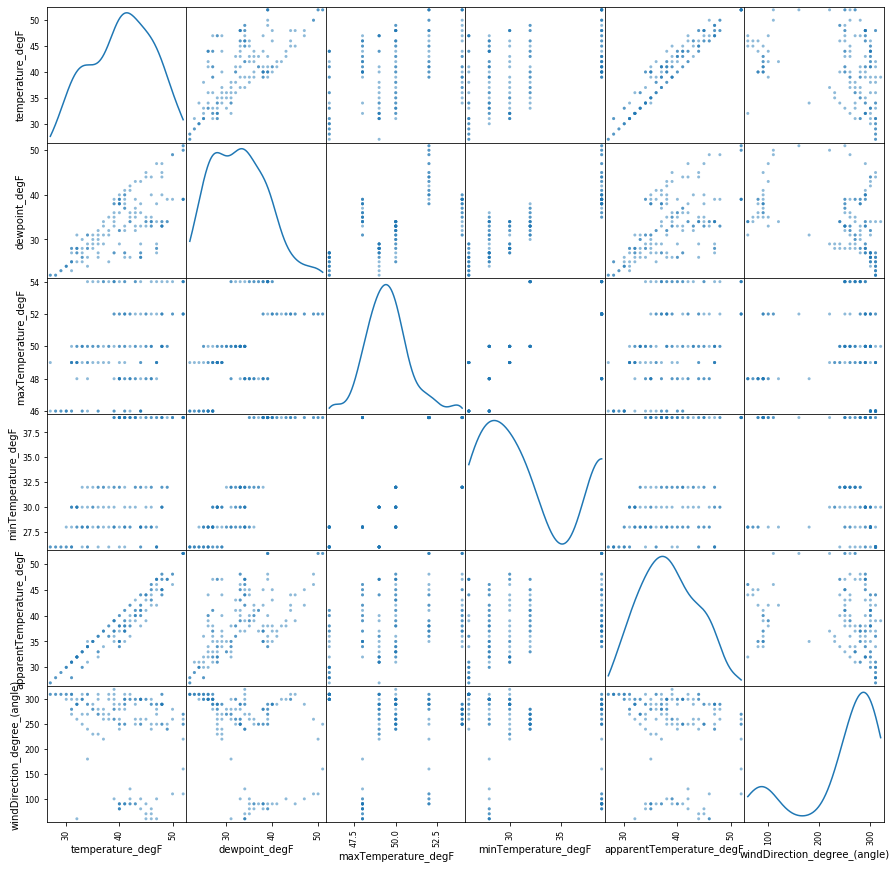

In [17]:
## Relationships with Temperature
scatter_matrix(bigDF.iloc[:,[1,3,5,7,10,16]], figsize=(15,15), diagonal='kde'); 

Remember that wind direction is a circle that is put on a linear plot. Points at the very top and very bottom are almost the same (i.e. 1 & 359 are only seperated by 2 degrees (0=360))

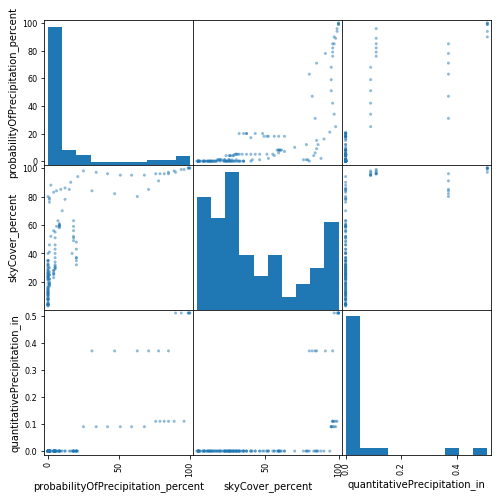

In [18]:
## Relationships with skyCover

scatter_matrix(bigDF.iloc[:,[21,15,23]], figsize=(8,8), diagonal='hist'); 

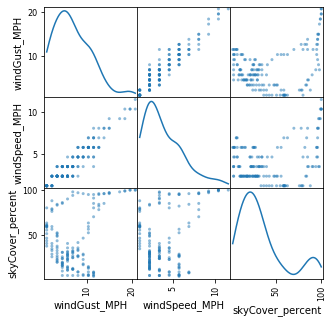

In [19]:
## Relationships with windSpeed

scatter_matrix(bigDF.iloc[:,[20,18,15]], figsize=(5,5), diagonal='kde'); 